# Seat availability at La Permanence: a first look at the data

[La Permanence](https://www.la-permanence.com) is a coworking space with two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  Our purpose in this repository is to model and then predict the number the available seats, and this will be done in separate notebooks.  In this notebook, our goal is simply to familiarize ourselves with the data.  The steps taken in this notebook will be performed as a preliminary to most other notebooks, without explanation.

## Imports

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 2  # 10
RULE = f"{RESOL}T"
# Duration of validation data
ONE_HOUR = 60 // RESOL
ONE_DAY = 24*ONE_HOUR
ONE_WEEK = 7*ONE_DAY
TWO_WEEKS = 2*ONE_WEEK
days_of_the_week = {0: 'Monday',
                    1: 'Tuesday', 
                    2: 'Wednesday',
                    3: 'Thursday',
                    4: 'Friday',
                    5: 'Saturday', 
                    6: 'Sunday'}

# Plotting
SAVEFIGS = False
FIGSIZE = (16, 6)
ALPHA = 0.7
# Colors 
COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
COL_AVG = plt.rcParams['axes.prop_cycle'].by_key()['color'][5]
COL_MED = plt.rcParams['axes.prop_cycle'].by_key()['color'][6]

## Functions

In [3]:
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()


def new_y_ticklabel(text):
    """Reformat text for y ticklabels in heatmaps"""
    ts = pd.to_datetime(text.get_text()).tz_localize(tz_utc).tz_convert(tz_paris)
    return ts.strftime('%d %b %Y | %a') if ts.weekday() == 0 else ts.strftime('%a')

# Data: loading and preparation
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

## Metadata on the dataset

In [4]:
filename = 'availability.csv'  # formerly: 'attendance.csv'
# foldername = 'Projects/la_permanence'
foldername = 'Data/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20  
# for display in this cell

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))

File size:          1MB
Number of rows:     76251
Names of columns:   timestamp, moulin, alesia


## More details on the columns
- `timestamp` gives the date and time (UTC) of data collection in the format `YYYY-MM-DD-hh-mm-ss` where 
  - `YYYY=`year,
  - `MM=`month,
  - `DD=`day,
  - `hh=`hour,
  - `mm=`minute,
  - `ss`=second;
- `Moulin` gives the number of available seats at the *rue du Fer à Moulin* location (maximum is 63);
- `Alésia` gives the number of available seats at the *rue d'Alésia* location (maximum is 82).  

## Load the data

In [5]:
%time
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')  # formerly: '%Y-%m-%d-%H-%M-%S'

raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'moulin': np.uint8, 'alesia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.78 µs


## Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [6]:
%time
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


## Time regularization

The data was collected at irregular times, as can be seen by zooming in on a short window frame:

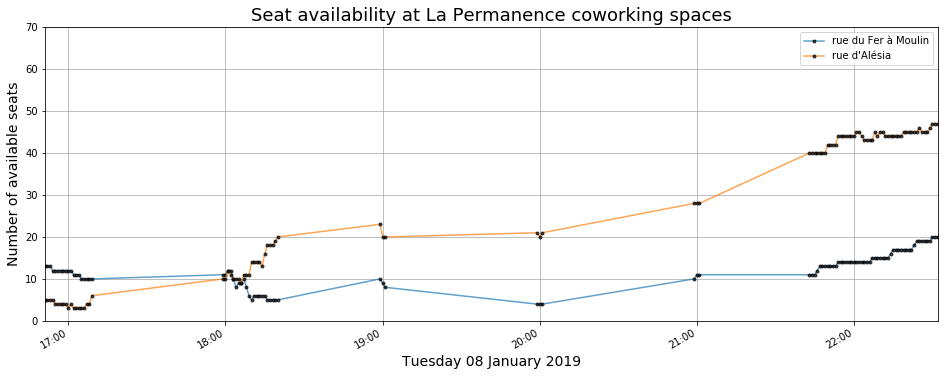

In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE)
idxs = range(100, 200)
window = raw_data.loc[idxs, raw_data.columns]
the_day = window.loc[window.index.min(), 'timestamp']
the_hours = list(set([x.hour for x in  window.loc[idxs, 'timestamp']]))

hour_range = pd.date_range(pd.Timestamp(the_day.year, the_day.month, the_day.day, the_day.hour), periods=the_hours[-1] - the_hours[0], freq= 'H')

window.set_index('timestamp').plot(style='-o', **{"markersize": 3, "markerfacecolor": "k", "markeredgecolor": "k"}, alpha=ALPHA, ax=ax);

ax.set_title("Seat availability at La Permanence coworking spaces", fontsize=18);

ax.set_ylabel("Number of available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));

ax.set_xlabel(the_day.strftime('%A %d %B %Y'), fontsize=14);
ax.set_xticks(hour_range);
ax.set_xticklabels([x.strftime("%H:00") for x in hour_range]);

ax.legend(["rue du Fer à Moulin", "rue d'Alésia"]);
ax.grid();

Thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [8]:
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

## Additional datetime features
For future use we extract now additional features from the `timestamp`.

In [28]:
%time 
raw_data['Date'] = raw_data['timestamp'].apply(
    lambda ts: pd.Timestamp(ts.year, ts.month, ts.day).tz_localize(tz_paris)
)

attributes = ['Dayofweek', 'Hour', 'Minute', 'Week']
for attr in attributes:
    raw_data[attr] = getattr(raw_data['timestamp'].dt, attr.lower())
raw_data['Minuteofday'] = 60*raw_data['Hour'] + raw_data['Minute']
raw_data['Minuteofweek'] = 24*60*raw_data['Dayofweek'] + raw_data['Minuteofday']
print("\nColumn names:\n\n{0}".format("\n".join(raw_data.columns)))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs

Column names:

timestamp
moulin
alesia
Date
Dayofweek
Hour
Minute
Week
Minuteofday
Minuteofweek


## Training and validation split
We wil
l shortly derive average values of the data, which can be used to make forecasts.  Thus we will work on a training dataset obtained by removing the last week's worth of data:

In [29]:
n_valid = ONE_WEEK
n_trn = raw_data.shape[0] - n_valid
train_data, valid_data = split_vals(raw_data, n_trn)
train_timestamps, valid_timestamps = split_vals(raw_data[['timestamp']], n_trn)

## Visualization of the timeseries

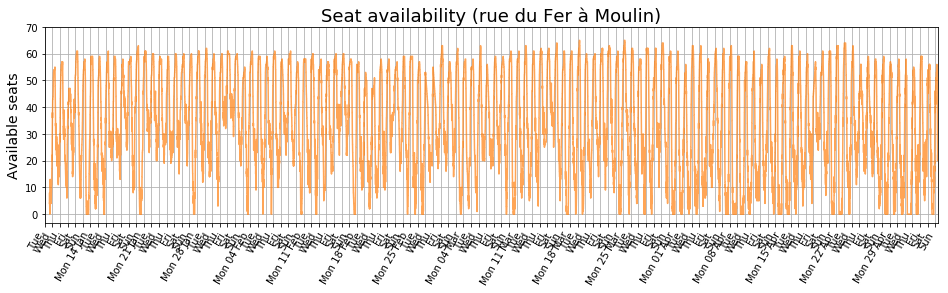

In [30]:
fig, ax = plt.subplots(figsize=(16, 4));

plt.subplots_adjust(hspace=0.6)

ts_min = raw_data['timestamp'].min()
ts_max = raw_data['timestamp'].max()
the_date_range = pd.date_range(ts_min.date(), ts_max.date());

# rue du Fer à Moulin
raw_data.plot(x='timestamp', y='moulin', color=COL_MOULIN, alpha=ALPHA, ax=ax);

ax.set_title("Seat availability (rue du Fer à Moulin)", fontsize=18)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10))

ax.axes.get_xaxis().label.set_visible(False);
ax.set_xticks(the_date_range);
ax.set_xticklabels([pd.to_datetime(x).strftime("%a %d %b")  #  %d %b %Y | %A
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in the_date_range])
ax.tick_params(axis='x', labelrotation=60)

ax.get_legend().remove();
ax.grid();
if SAVEFIGS:
    plt.savefig("moulin-availability-timeseries.png");

# Averaging

Now we derive a representative for each day of the week.  

## Averages by day

In [31]:
moulin = train_data.set_index('timestamp').drop('alesia', axis=1)
moulin_by_day_of_week = pd.pivot_table(moulin, index=moulin.index.hour, columns=moulin.index.dayofweek, values='moulin', aggfunc='mean')

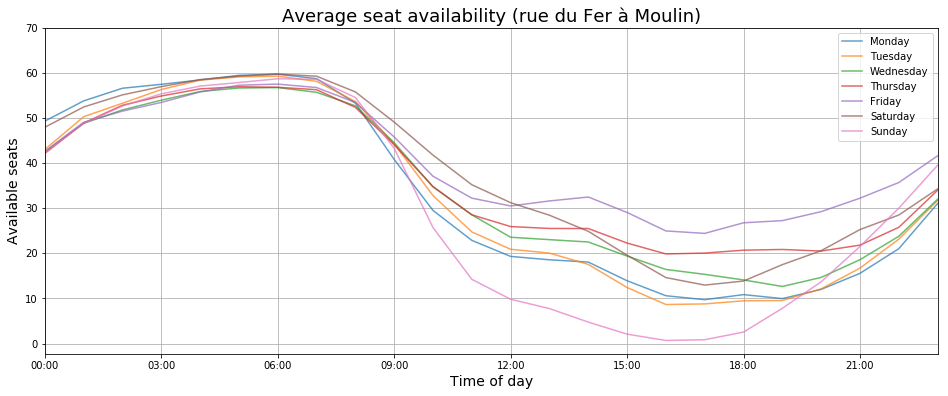

In [32]:
fig, ax = plt.subplots(figsize=(16, 6))

plt.subplots_adjust(hspace=0.4)

moulin_by_day_of_week.plot(alpha=ALPHA, ax=ax);

ax.set_title("Average seat availability (rue du Fer à Moulin)", fontsize=18)
ax.set_ylabel("Available seats", fontsize=14)
ax.set_xlabel("Time of day", fontsize=14)

ax.set_yticks(range(0, 80, 10))
ax.set_xticks(range(0,24, 3))
ax.set_xticklabels(["{:02d}:00".format(x) for x in ax.get_xticks()])

ax.legend(days_of_the_week.values())
ax.grid()
if SAVEFIGS:
    plt.savefig("moulin-average-by-day.png")


We can see that the different days of the week have distinct average behaviour.  Is there a lot of variation about these representatives?  Can we have a sense of the distribution of the seat availability over the different weeks of data?

# Aggregate plots

We will now superpose plots of the data over entire days and weeks.  To this end we generate pivot tables.

## Daily view
Rearrange the (entire) dataset, one day per row:

In [33]:
daily_pivot = pd.pivot_table(raw_data, index='Date', columns='Minuteofday', values='moulin')

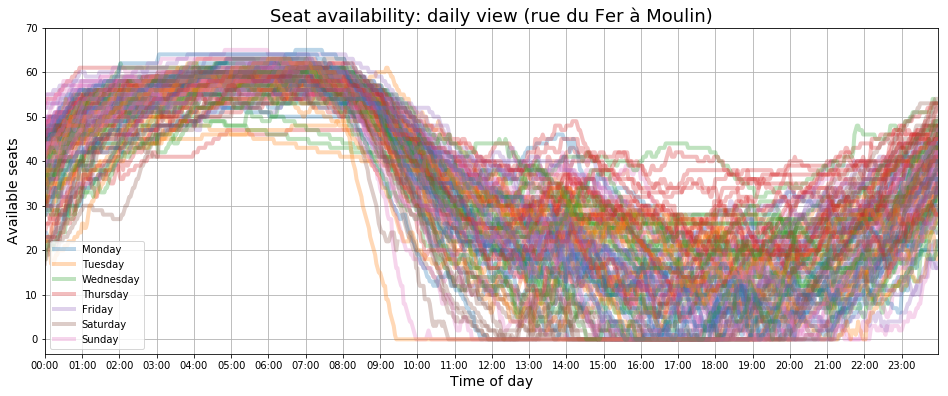

In [34]:
fig, ax = plt.subplots(figsize=FIGSIZE);

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:7]
ax.set_prop_cycle('color', colors)
daily_pivot.transpose().plot(style='-', linewidth=4, alpha=0.3, ax=ax);

ax.set_title("Seat availability: daily view (rue du Fer à Moulin)", fontsize=18);

ax.set_xticks([h*ONE_HOUR*RESOL for h in range(0, 24)])
ax.set_xticklabels(["{0:02d}:00".format(x//ONE_HOUR//RESOL) for x in ax.get_xticks()])
ax.set_xlabel("Time of day", fontsize=14);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));


ax.legend(days_of_the_week.values(), loc='lower left');
ax.grid();
if SAVEFIGS:
    plt.savefig('moulin-daily-availability.png')

It is quite difficult to get a sense of what is going on.  Things are a bit more instructive when looking at entire weeks.

## Weekly view
Rearrange the (training and validation) datasets, one week per row:

In [35]:
weekly_train_pivot = pd.pivot_table(train_data, index='Week', columns='Minuteofweek', values='moulin')
weekly_valid_pivot = pd.pivot_table(valid_data, index='Week', columns='Minuteofweek', values='moulin')

In [36]:
weekly_valid_pivot

Minuteofweek,0,2,4,6,8,10,12,14,16,18,...,10060,10062,10064,10066,10068,10070,10072,10074,10076,10078
Week,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.0,34.0,35.0,35.0,36.0,36.0,37.0,37.0,38.0,38.0
18,40.0,40.0,40.0,40.0,40.0,40.0,40.0,41.0,41.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate weekly averages over training set:

In [37]:
weekly_train_avg = train_data.groupby('Minuteofweek')[['moulin']].mean().round().astype(np.int8).reset_index()

In the following, we plot the training data (in green), its average (in black), and the data for the last week of the validation set (in red):

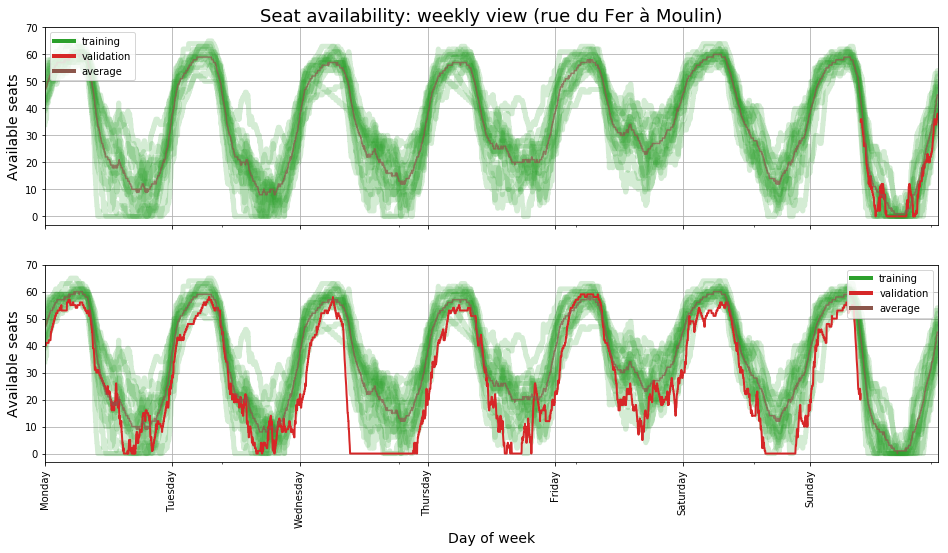

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True);

custom_lines = [Line2D([0], [0], color=COL_TRAIN, lw=4),
                Line2D([0], [0], color=COL_VALID, lw=4),
                Line2D([0], [0], color=COL_AVG, lw=4)]

ax1.set_prop_cycle('color', colors)

weekly_train_pivot.transpose().plot(style='-', linewidth=5, color=COL_TRAIN, alpha=0.2, ax=ax1);
if weekly_valid_pivot.shape[0] > 1:
    weekly_valid_pivot.iloc[-2].plot(style='-', linewidth=2, color=COL_VALID, alpha=1, ax=ax1);
ax1.plot(weekly_train_avg['Minuteofweek'], weekly_train_avg['moulin'], COL_AVG, alpha=ALPHA);

ax1.set_title("Seat availability: weekly view (rue du Fer à Moulin)", fontsize=18);

ax1.set_xticks([d*ONE_DAY*RESOL for d in range(0, 7)])
ax1.set_xticklabels(days_of_the_week.values());
# ax1.set_xlabel("Day of week", fontsize=14);
ax1.tick_params(axis='x', labelrotation=90);

ax1.set_ylabel("Available seats", fontsize=14);
ax1.set_yticks(range(0, 80, 10));

# ax1.get_legend().remove();
# ax1.legend(['])
ax1.legend(custom_lines, ['training', 'validation', 'average'], loc='upper left');
ax1.grid();

ax2.set_prop_cycle('color', colors)

weekly_train_pivot.transpose().plot(style='-', linewidth=5, color=COL_TRAIN, alpha=0.2, ax=ax2);
weekly_valid_pivot.iloc[-1].plot(style='-', linewidth=2, color=COL_VALID, alpha=1, ax=ax2);
ax2.plot(weekly_train_avg['Minuteofweek'], weekly_train_avg['moulin'], color=COL_AVG, alpha=ALPHA);

ax2.set_xticks([d*ONE_DAY*RESOL for d in range(0, 7)])
ax2.set_xticklabels(days_of_the_week.values());
ax2.set_xlabel("Day of week", fontsize=14);
ax2.tick_params(axis='x', labelrotation=90);

ax2.set_ylabel("Available seats", fontsize=14);
ax2.set_yticks(range(0, 80, 10));

ax2.legend(custom_lines, ['training', 'validation', 'average'], loc='upper right');
ax2.grid();

if SAVEFIGS:
    plt.savefig('moulin-weekly-timeseries.png')

This plot gives some visual evidence that the training data (in green) is well represented by its average (in black).  The deviation seems to be due to a few outlying values (some of which are actually interpolated values replacing missing data).  The validation set turns out to be quite distinct from the previous weeks, and it is not too surprising that the average does not predict it very well.

# Using the median

In [39]:
weekly_train_med = train_data.groupby('Minuteofweek')[['moulin']].median().round().astype(np.int8).reset_index()

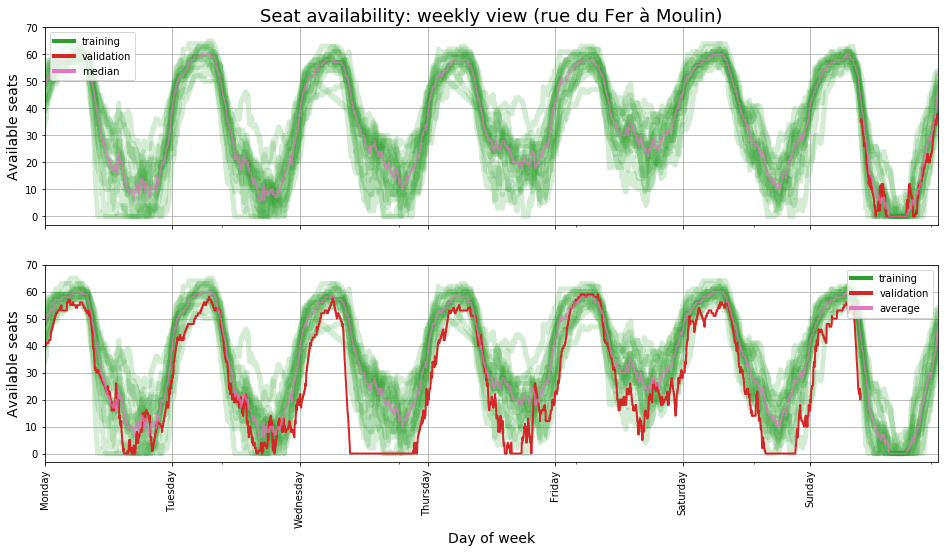

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True);

custom_lines = [Line2D([0], [0], color=COL_TRAIN, lw=4),
                Line2D([0], [0], color=COL_VALID, lw=4),
                Line2D([0], [0], color=COL_MED, lw=4)]

ax1.set_prop_cycle('color', colors)

weekly_train_pivot.transpose().plot(style='-', linewidth=5, color=COL_TRAIN, alpha=0.2, ax=ax1);
if weekly_valid_pivot.shape[0] > 1:
    weekly_valid_pivot.iloc[-2].plot(style='-', linewidth=2, color=COL_VALID, alpha=1, ax=ax1);
ax1.plot(weekly_train_med['Minuteofweek'], weekly_train_med['moulin'], color=COL_MED, alpha=ALPHA);

ax1.set_title("Seat availability: weekly view (rue du Fer à Moulin)", fontsize=18);

ax1.set_xticks([d*ONE_DAY*RESOL for d in range(0, 7)])
ax1.set_xticklabels(days_of_the_week.values());
ax1.set_xlabel("Day of week", fontsize=14);
ax1.tick_params(axis='x', labelrotation=90);

ax1.set_ylabel("Available seats", fontsize=14);
ax1.set_yticks(range(0, 80, 10));

# ax1.get_legend().remove();
# ax1.legend(['])
ax1.legend(custom_lines, ['training', 'validation', 'median'], loc='upper left');
ax1.grid();

ax2.set_prop_cycle('color', colors)

weekly_train_pivot.transpose().plot(style='-', linewidth=5, color=COL_TRAIN, alpha=0.2, ax=ax2);
weekly_valid_pivot.iloc[-1].plot(style='-', linewidth=2, color=COL_VALID, alpha=1, ax=ax2);
ax2.plot(weekly_train_med['Minuteofweek'], weekly_train_med['moulin'], color=COL_MED, alpha=ALPHA);

ax2.set_xticks([d*ONE_DAY*RESOL for d in range(0, 7)])
ax2.set_xticklabels(days_of_the_week.values());
ax2.set_xlabel("Day of week", fontsize=14);
ax2.tick_params(axis='x', labelrotation=90);

ax2.set_ylabel("Available seats", fontsize=14);
ax2.set_yticks(range(0, 80, 10));

ax2.legend(custom_lines, ['training', 'validation', 'average'], loc='upper right');
ax2.grid();

if SAVEFIGS:
    plt.savefig('moulin-weekly-timeseries.png')

# Comparing median and average

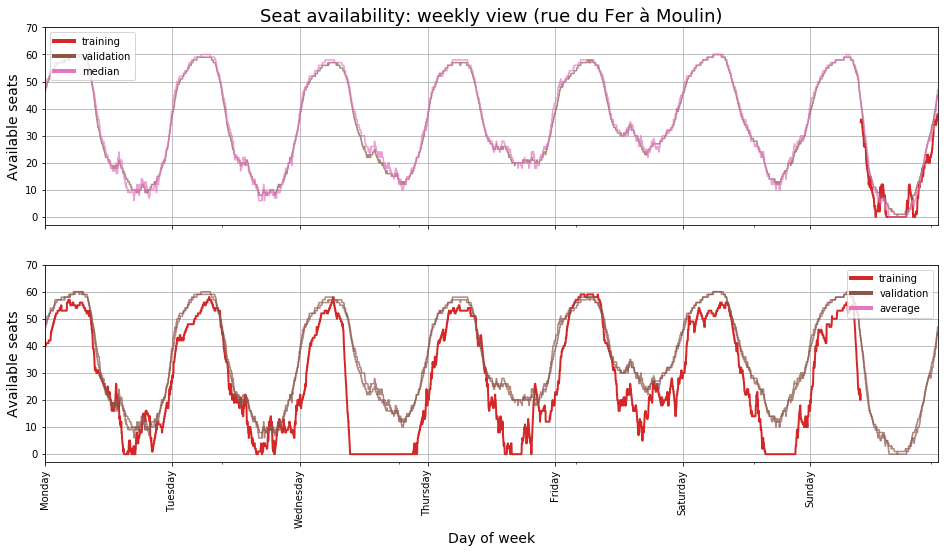

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True);

custom_lines = [ 
    #Line2D([0], [0], color=COL_TRAIN, lw=4),
    Line2D([0], [0], color=COL_VALID, lw=4),
    Line2D([0], [0], color=COL_AVG, lw=4),
    Line2D([0], [0], color=COL_MED, lw=4),
]

ax1.set_prop_cycle('color', colors)

#weekly_train_pivot.transpose().plot(style='-', linewidth=5, color=COL_TRAIN, alpha=0.2, ax=ax1);
if weekly_valid_pivot.shape[0] > 1:
    weekly_valid_pivot.iloc[-2].plot(style='-', linewidth=2, color=COL_VALID, alpha=1, ax=ax1);
ax1.plot(weekly_train_avg['Minuteofweek'], weekly_train_avg['moulin'], color=COL_AVG, alpha=ALPHA);
ax1.plot(weekly_train_med['Minuteofweek'], weekly_train_med['moulin'], color=COL_MED, alpha=ALPHA);


ax1.set_title("Seat availability: weekly view (rue du Fer à Moulin)", fontsize=18);

ax1.set_xticks([d*ONE_DAY*RESOL for d in range(0, 7)])
ax1.set_xticklabels(days_of_the_week.values());
ax1.set_xlabel("Day of week", fontsize=14);
ax1.tick_params(axis='x', labelrotation=90);

ax1.set_ylabel("Available seats", fontsize=14);
ax1.set_yticks(range(0, 80, 10));

# ax1.get_legend().remove();
# ax1.legend(['])
ax1.legend(custom_lines, ['training', 'validation', 'median'], loc='upper left');
ax1.grid();

ax2.set_prop_cycle('color', colors)

# weekly_train_pivot.transpose().plot(style='-', linewidth=5, color=COL_TRAIN, alpha=0.2, ax=ax2);
weekly_valid_pivot.iloc[-1].plot(style='-', linewidth=2, color=COL_VALID, alpha=1, ax=ax2);
ax2.plot(weekly_train_avg['Minuteofweek'], weekly_train_avg['moulin'], color=COL_AVG, alpha=ALPHA);
ax2.plot(weekly_train_med['Minuteofweek'], weekly_train_med['moulin'], color=COL_AVG, alpha=ALPHA);


ax2.set_xticks([d*ONE_DAY*RESOL for d in range(0, 7)])
ax2.set_xticklabels(days_of_the_week.values());
ax2.set_xlabel("Day of week", fontsize=14);
ax2.tick_params(axis='x', labelrotation=90);

ax2.set_ylabel("Available seats", fontsize=14);
ax2.set_yticks(range(0, 80, 10));

ax2.legend(custom_lines, ['training', 'validation', 'average'], loc='upper right');
ax2.grid();

if SAVEFIGS:
    plt.savefig('moulin-weekly-timeseries.png')

# Visualization with heatmaps
With the pivot tables from above we can also generate an alternattive representation of the data using heatmaps.  

## Visualizing historical data with a heatmap
We first view the entire dataset with a heatmap:

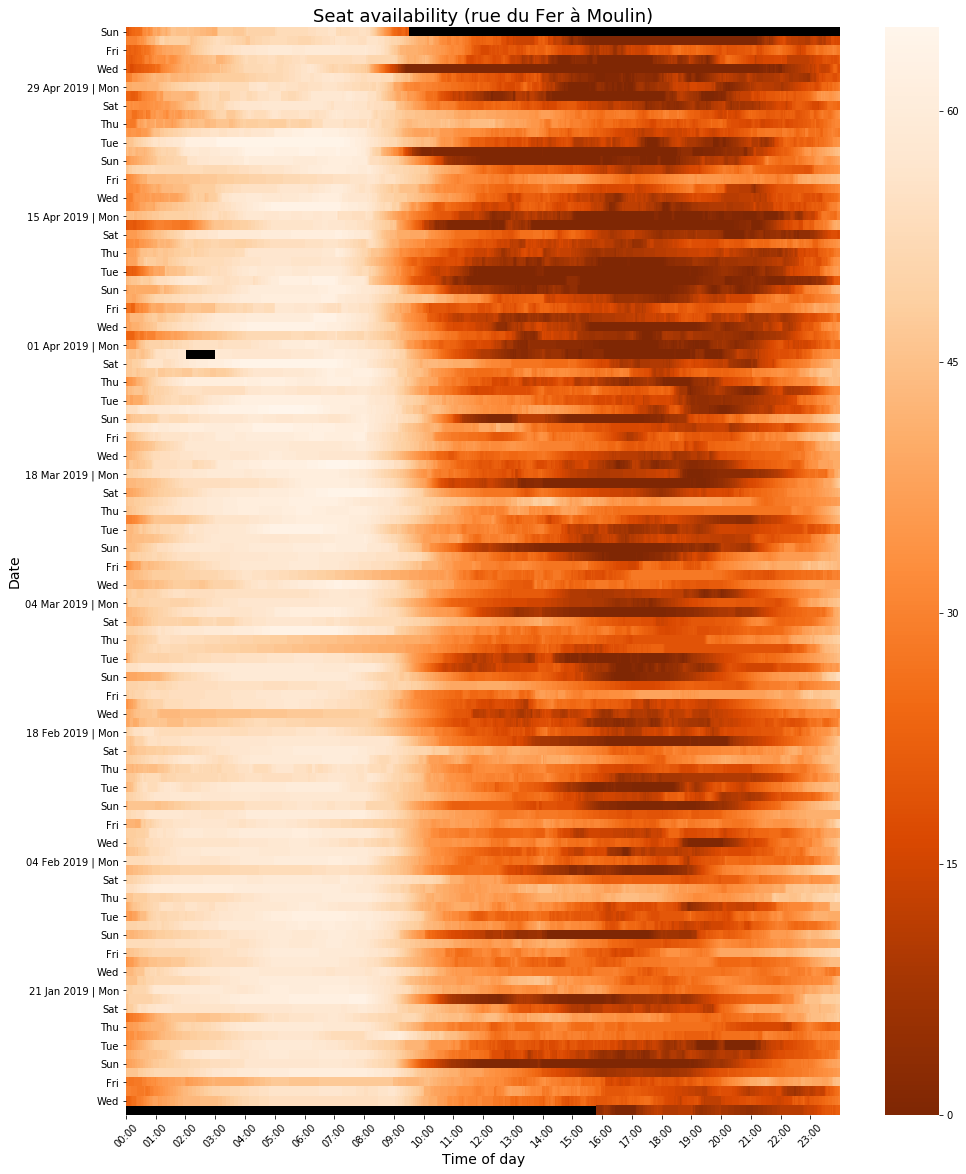

In [42]:
fig, ax = plt.subplots(figsize=(16, 20));

ax.set_facecolor("black")
mask = daily_pivot.sort_index(ascending=False).isnull()
sns.heatmap(daily_pivot.sort_index(ascending=False),
            cmap="Oranges_r",
            mask=mask,
            ax=ax);

ax.set_xlabel("Time of day", fontsize=14);
ax.set_xticks([h*ONE_HOUR for h in range(0, 24)]);
ax.set_xlabel("Time of day", fontsize=14);
ax.set_xticks([h*ONE_HOUR for h in range(0, 24)]);
ax.set_xticklabels(["{0:02d}:00".format(x//ONE_HOUR) for x in ax.get_xticks()])
ax.tick_params(axis='x', labelrotation=45);

ax.set_yticklabels([new_y_ticklabel(text) for text in ax.get_yticklabels()]);
ax.set_ylabel("Date", fontsize=14);
ax.tick_params(axis='y', labelrotation=0);

ax.set_title("Seat availability (rue du Fer à Moulin)", fontsize=18);
if SAVEFIGS:
    plt.savefig("moulin-availability-heatmap.png");

### Inspecting missing data

The black cells represent missing data.  

Some of these missing data were created while generating the pivot table.  Indeed, data was missing at the beginning of the first day of data collection, and data is not yet available for the remainder of the last day of data collection.  Let's set these values to `-1`:

In [43]:
# Missing data at beginning of first day
daily_pivot.iloc[0].fillna(value=-1, inplace=True)  
# Missing data at end of last day
daily_pivot.iloc[-1].fillna(method='ffill', inplace=True)

In addition, there are missing data on Sun 31 Apr 2019.  These are actually due to the switch to daylight saving time in France, which occurs at 2am.  Let's find them in the pivot table:

In [44]:
nan_rows = np.where(daily_pivot.apply(axis=1, func=lambda x : any(pd.isnull(x))))
nan_cols = np.where(daily_pivot.apply(axis=0, func=lambda x : any(pd.isnull(x))))
len(nan_rows[0]), len(nan_cols[0])

(1, 30)

There remains `1` row with `30` `nan` values:

In [45]:
daily_pivot.iloc[nan_rows[0], nan_cols[0]]

Minuteofday,120,122,124,126,128,130,132,134,136,138,...,160,162,164,166,168,170,172,174,176,178
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-31 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Indeed, these occur between 2am and 3am (between minute `2*60 = 120` and `3*60 = 180`).

In [46]:
daily_pivot.fillna(value=-1, inplace=True)
daily_pivot = daily_pivot.astype(np.int8)

## Visualizing averages with a heatmap
To represent the average data, we calculate another pivot table (alternatively, we could have added a bit more to `weekly_avg` above).

In [47]:
train_avg = train_data.groupby(['Dayofweek', 'Minuteofday']).apply(lambda x: x['moulin'].mean().round().astype(np.uint8)).reset_index()
train_avg.rename(columns={0: 'moulin'}, inplace=True)

In [48]:
train_avg_pivot = pd.pivot_table(train_avg, index='Dayofweek', columns='Minuteofday', values='moulin')
train_avg_pivot.fillna(train_avg_pivot.mean(axis=0), inplace=True)

In [49]:
df = train_data[['Dayofweek', 'Minuteofday', 'moulin']].copy()
df = df.groupby(['Dayofweek', 'Minuteofday']).mean().round().astype(np.uint8).reset_index()
pv = pd.pivot_table(df, index='Dayofweek', columns='Minuteofday', values='moulin')
pv.head()

Minuteofday,0,2,4,6,8,10,12,14,16,18,...,1420,1422,1424,1426,1428,1430,1432,1434,1436,1438
Dayofweek,,,,,,,,,,,,,,,,,,,,,
0,46,46,47,47,47,47,48,48,48,48,...,34,34,34,35,36,36,36,37,37,38
1,38,38,38,39,39,39,40,40,40,41,...,33,34,34,34,35,35,35,36,36,37
2,38,38,38,39,39,39,39,40,40,41,...,34,35,35,35,35,36,36,36,36,36
3,37,38,38,38,39,39,39,39,40,40,...,36,36,36,37,37,38,38,38,38,38
4,38,39,39,39,40,40,40,40,40,41,...,42,43,43,43,44,44,44,44,45,45


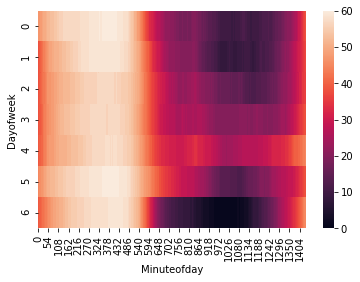

In [50]:
sns.heatmap(pv)

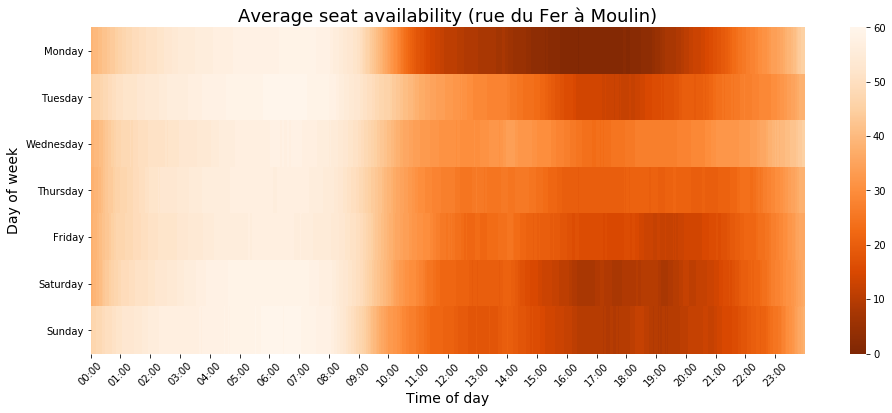

In [51]:
fig, ax = plt.subplots(figsize=FIGSIZE);

sns.heatmap(train_avg_pivot.sort_index(ascending=False),
          # annot=True,
            cmap="Oranges_r",
            # linewidths=.5, fmt='.3g',
            ax=ax);
ax.set_xlabel("Time of day", fontsize=14);
ax.set_xticks([h*ONE_HOUR for h in range(0, 24)]);
ax.set_xticklabels(["{0:02d}:00".format(x//ONE_HOUR) for x in ax.get_xticks()])
ax.tick_params(axis='x', labelrotation=45);
ax.set_yticklabels(days_of_the_week.values());
ax.set_title("Average seat availability (rue du Fer à Moulin)", fontsize=18);
ax.set_ylabel("Day of week", fontsize=14);
ax.tick_params(axis='y', labelrotation=0);
if SAVEFIGS:
    plt.savefig('moulin-average-heatmap.png')

In [52]:
train_avg_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Columns: 720 entries, 0 to 1438
dtypes: int64(720)
memory usage: 39.4 KB


In [53]:
enumerate(train_avg_pivot.columns.values)

In [54]:
raw_data.columns

Index(['timestamp', 'moulin', 'alesia', 'Date', 'Dayofweek', 'Hour', 'Minute',
       'Week', 'Minuteofday', 'Minuteofweek'],
      dtype='object')

In [55]:
train_avg_pivot.columns

Int64Index([   0,    2,    4,    6,    8,   10,   12,   14,   16,   18,
            ...
            1420, 1422, 1424, 1426, 1428, 1430, 1432, 1434, 1436, 1438],
           dtype='int64', name='Minuteofday', length=720)

In [56]:
type(daily_pivot.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [57]:
dh = pd.DataFrame(daily_pivot.index)

In [58]:
dh.head()

,Date
0,2019-01-08 00:00:00+01:00
1,2019-01-09 00:00:00+01:00
2,2019-01-10 00:00:00+01:00
3,2019-01-11 00:00:00+01:00
4,2019-01-12 00:00:00+01:00


In [59]:
daily_pivot.index.strftime('%Y')

Index(['2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019',
       '2019',
       ...
       '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019',
       '2019'],
      dtype='object', length=118)

In [60]:
daily_pivot.columns.name

'Minuteofday'

In [61]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84021 entries, 0 to 84020
Data columns (total 10 columns):
timestamp       84021 non-null datetime64[ns, Europe/Paris]
moulin          84021 non-null uint8
alesia          84021 non-null uint8
Date            84021 non-null datetime64[ns, Europe/Paris]
Dayofweek       84021 non-null int64
Hour            84021 non-null int64
Minute          84021 non-null int64
Week            84021 non-null int64
Minuteofday     84021 non-null int64
Minuteofweek    84021 non-null int64
dtypes: datetime64[ns, Europe/Paris](2), int64(6), uint8(2)
memory usage: 5.3 MB


In [62]:
raw_data.columns.name is None

True

In [63]:
raw_data.head()

,timestamp,moulin,alesia,Date,Dayofweek,Hour,Minute,Week,Minuteofday,Minuteofweek
0,2019-01-08 15:48:00+01:00,4,9,2019-01-08 00:00:00+01:00,1,15,48,2,948,2388
1,2019-01-08 15:50:00+01:00,4,8,2019-01-08 00:00:00+01:00,1,15,50,2,950,2390
2,2019-01-08 15:52:00+01:00,4,6,2019-01-08 00:00:00+01:00,1,15,52,2,952,2392
3,2019-01-08 15:54:00+01:00,4,6,2019-01-08 00:00:00+01:00,1,15,54,2,954,2394
4,2019-01-08 15:56:00+01:00,4,6,2019-01-08 00:00:00+01:00,1,15,56,2,956,2396


In [64]:
raw_data.set_index('timestamp').index.to_series().apply(lambda ts: ts.year).head()

/anaconda3/envs/lapermanence/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  """Entry point for launching an IPython kernel.


timestamp
2019-01-08 15:48:00+01:00    2019
2019-01-08 15:50:00+01:00    2019
2019-01-08 15:52:00+01:00    2019
2019-01-08 15:54:00+01:00    2019
2019-01-08 15:56:00+01:00    2019
Freq: 2T, Name: timestamp, dtype: int64

In [65]:
raw_data['timestamp'].dt.date

0        2019-01-08
1        2019-01-08
2        2019-01-08
3        2019-01-08
4        2019-01-08
5        2019-01-08
6        2019-01-08
7        2019-01-08
8        2019-01-08
9        2019-01-08
10       2019-01-08
11       2019-01-08
12       2019-01-08
13       2019-01-08
14       2019-01-08
15       2019-01-08
16       2019-01-08
17       2019-01-08
18       2019-01-08
19       2019-01-08
20       2019-01-08
21       2019-01-08
22       2019-01-08
23       2019-01-08
24       2019-01-08
25       2019-01-08
26       2019-01-08
27       2019-01-08
28       2019-01-08
29       2019-01-08
            ...    
83991    2019-05-05
83992    2019-05-05
83993    2019-05-05
83994    2019-05-05
83995    2019-05-05
83996    2019-05-05
83997    2019-05-05
83998    2019-05-05
83999    2019-05-05
84000    2019-05-05
84001    2019-05-05
84002    2019-05-05
84003    2019-05-05
84004    2019-05-05
84005    2019-05-05
84006    2019-05-05
84007    2019-05-05
84008    2019-05-05
84009    2019-05-05


In [66]:
raw_data.set_index('timestamp')['moulin'].head()

timestamp
2019-01-08 15:48:00+01:00    4
2019-01-08 15:50:00+01:00    4
2019-01-08 15:52:00+01:00    4
2019-01-08 15:54:00+01:00    4
2019-01-08 15:56:00+01:00    4
Freq: 2T, Name: moulin, dtype: uint8

In [67]:
bob = raw_data.set_index('timestamp')['moulin']

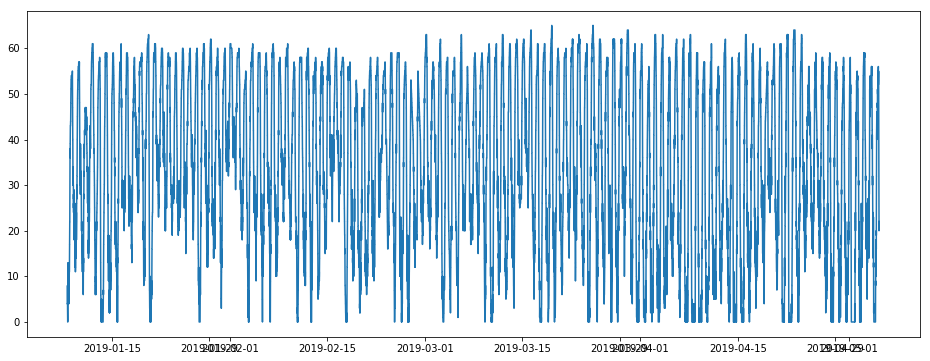

In [68]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(bob)
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()

In [69]:
xticks

array([737074., 737088., 737091., 737105., 737119., 737133., 737147.,
       737150., 737164., 737178., 737180.])

In [70]:
xticklabels

<a list of 11 Text xticklabel objects>

In [71]:
xticks[-1] - xticks[0]

106.0

In [72]:
xticklabels[0], xticklabels[-1]

(Text(737074.0, 0, '2019-01-15'), Text(737180.0, 0, '2019-05-01'))

In [73]:
bob.index[-1] - bob.index[0]

Timedelta('116 days 16:40:00')

In [79]:
train_avg_pivot.index.dtype, train_avg_pivot.columns.dtype

(dtype('int64'), dtype('int64'))

In [80]:
daily_pivot.index.dtype, daily_pivot.columns.dtype

(datetime64[ns, Europe/Paris], dtype('int64'))

In [81]:
raw_data.columns

Index(['timestamp', 'moulin', 'alesia', 'Date', 'Dayofweek', 'Hour', 'Minute',
       'Week', 'Minuteofday', 'Minuteofweek'],
      dtype='object')

In [82]:
raw_data.dtypes

timestamp       datetime64[ns, Europe/Paris]
moulin                                 uint8
alesia                                 uint8
Date            datetime64[ns, Europe/Paris]
Dayofweek                              int64
Hour                                   int64
Minute                                 int64
Week                                   int64
Minuteofday                            int64
Minuteofweek                           int64
dtype: object

In [94]:
joe = raw_data.copy()

In [95]:
joe['Date'] = pd.to_datetime(joe['Date'].dt.date)

In [96]:
joe.dtypes

timestamp       datetime64[ns, Europe/Paris]
moulin                                 uint8
alesia                                 uint8
Date                          datetime64[ns]
Dayofweek                              int64
Hour                                   int64
Minute                                 int64
Week                                   int64
Minuteofday                            int64
Minuteofweek                           int64
dtype: object

In [92]:
joe.head()

,timestamp,moulin,alesia,Date,Dayofweek,Hour,Minute,Week,Minuteofday,Minuteofweek
0,2019-01-08 15:48:00+01:00,4,9,2019-01-08,1,15,48,2,948,2388
1,2019-01-08 15:50:00+01:00,4,8,2019-01-08,1,15,50,2,950,2390
2,2019-01-08 15:52:00+01:00,4,6,2019-01-08,1,15,52,2,952,2392
3,2019-01-08 15:54:00+01:00,4,6,2019-01-08,1,15,54,2,954,2394
4,2019-01-08 15:56:00+01:00,4,6,2019-01-08,1,15,56,2,956,2396


In [99]:
joe.index.freq

AttributeError: 'RangeIndex' object has no attribute 'freq'

In [143]:
joe['timestamp'].index.freqstr

AttributeError: 'RangeIndex' object has no attribute 'freqstr'